# Multi Variate Analysis 
This jupyter python notebook conducts multi variate analysis relevant to the research question. The research questions is as follows: <br>
<br>
How different variables such as **actual delivery time**, **the difference between actual and estimated wait time**, **freight value**, **payment value**, **payment installment** affect the **review score** in each of the different **product type categories**, `Houseware`, `auto`, `furniture decor`, `computer accessories`, `health beauty`, `sports leisure`? <br>

However, in this python notebook, random forest is used to help better the machine learning. Decision tree is not the best solution as seen in part 5. A decision tree is a single classification tree. A random forest on the other hand is a "forest", a multitude of classification trees. The random forest algorithm then decides which is the best tree with the lowest error rates. 
https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm 


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

In [2]:
olist_orders_dataset = pd.read_csv("olist_orders_dataset.csv")
olist_order_reviews_dataset = pd.read_csv("olist_order_reviews_dataset.csv")
olist_order_payments_dataset = pd.read_csv("olist_order_payments_dataset.csv")
olist_order_items_dataset = pd.read_csv("olist_order_items_dataset.csv")
olist_products_dataset = pd.read_csv("olist_products_dataset.csv")
product_category_name_translation = pd.read_csv("product_category_name_translation.csv")

### Merging the Datasets

In [3]:
olist_merge = olist_orders_dataset.merge(olist_order_reviews_dataset, on="order_id", how = 'left')
olist_merge = olist_merge.merge(olist_order_payments_dataset, on="order_id", how = 'left')
olist_merge = olist_merge.merge(olist_order_items_dataset, on="order_id", how = 'left')
olist_merge = olist_merge.merge(olist_products_dataset, on="product_id", how = 'left')

### Removing Duplicates and extracting needed variables 

In [4]:
olist_merge.drop_duplicates(subset=["review_score", "order_id"], inplace = True)

In [5]:
olist_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99650 entries, 0 to 119150
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       99650 non-null  object 
 1   customer_id                    99650 non-null  object 
 2   order_status                   99650 non-null  object 
 3   order_purchase_timestamp       99650 non-null  object 
 4   order_approved_at              99490 non-null  object 
 5   order_delivered_carrier_date   97860 non-null  object 
 6   order_delivered_customer_date  96672 non-null  object 
 7   order_estimated_delivery_date  99650 non-null  object 
 8   review_id                      99650 non-null  object 
 9   review_score                   99650 non-null  int64  
 10  review_comment_title           11704 non-null  object 
 11  review_comment_message         41646 non-null  object 
 12  review_creation_date           99650 non-null

In [6]:
dataAnalysis = pd.DataFrame(olist_merge[['order_status','order_purchase_timestamp', 'order_approved_at', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'review_score', 'payment_installments', 'payment_value', 'freight_value', 'product_category_name']])

In [7]:
dataAnalysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99650 entries, 0 to 119150
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_status                   99650 non-null  object 
 1   order_purchase_timestamp       99650 non-null  object 
 2   order_approved_at              99490 non-null  object 
 3   order_delivered_customer_date  96672 non-null  object 
 4   order_estimated_delivery_date  99650 non-null  object 
 5   review_score                   99650 non-null  int64  
 6   payment_installments           99649 non-null  float64
 7   payment_value                  99649 non-null  float64
 8   freight_value                  98874 non-null  float64
 9   product_category_name          97454 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 8.4+ MB


In [8]:
# Creating a list of the time related variables 
time = ["order_purchase_timestamp","order_estimated_delivery_date","order_delivered_customer_date", "order_approved_at"]
# Changing the time related variables to datetime format using the list 
for column in time:
    dataAnalysis.loc[:, column] = pd.to_datetime(dataAnalysis[column])

In [9]:
# Calculating the actual wait time    
dataAnalysis.loc[:,"actual_wait_time"] = (dataAnalysis['order_delivered_customer_date']-dataAnalysis['order_purchase_timestamp']).dt.days

In [10]:
# Calculating the estimated wait time 
dataAnalysis.loc[:,"estimated_wait_time"] = (dataAnalysis['order_estimated_delivery_date']-dataAnalysis['order_purchase_timestamp']).dt.days

In [11]:
#Actual minus estimated wait time 
dataAnalysis.loc[:,"actualxestimated"] = (dataAnalysis['actual_wait_time']-dataAnalysis['estimated_wait_time'])

In [12]:
dataAnalysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99650 entries, 0 to 119150
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_status                   99650 non-null  object        
 1   order_purchase_timestamp       99650 non-null  datetime64[ns]
 2   order_approved_at              99490 non-null  datetime64[ns]
 3   order_delivered_customer_date  96672 non-null  datetime64[ns]
 4   order_estimated_delivery_date  99650 non-null  datetime64[ns]
 5   review_score                   99650 non-null  int64         
 6   payment_installments           99649 non-null  float64       
 7   payment_value                  99649 non-null  float64       
 8   freight_value                  98874 non-null  float64       
 9   product_category_name          97454 non-null  object        
 10  actual_wait_time               96672 non-null  float64       
 11  estimated_wait

In [13]:
dataAnalysis.drop(columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'estimated_wait_time'], inplace = True)

In [14]:
dataAnalysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99650 entries, 0 to 119150
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   order_status           99650 non-null  object 
 1   review_score           99650 non-null  int64  
 2   payment_installments   99649 non-null  float64
 3   payment_value          99649 non-null  float64
 4   freight_value          98874 non-null  float64
 5   product_category_name  97454 non-null  object 
 6   actual_wait_time       96672 non-null  float64
 7   actualxestimated       96672 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 6.8+ MB


### Further analysis of predictors
Categorical types: Order Status
<br>
Numerical types: payment installments, payment value, freight value, actual wait time, actualxestimated 

When conducting multi variate analysis, it is important to know which variables are categorical and which are numerical. 

The numerical types are dependent on the order status being delivered. Hence, it needs to be filtered. 

In [15]:
dataAnalysis = dataAnalysis.loc[(dataAnalysis["order_status"]=="delivered")]

In [16]:
dataAnalysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96674 entries, 0 to 119150
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   order_status           96674 non-null  object 
 1   review_score           96674 non-null  int64  
 2   payment_installments   96673 non-null  float64
 3   payment_value          96673 non-null  float64
 4   freight_value          96674 non-null  float64
 5   product_category_name  95312 non-null  object 
 6   actual_wait_time       96666 non-null  float64
 7   actualxestimated       96666 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 6.6+ MB


### Class balancing for review score into low and high review score 
Review score 1 and 2 classified as low (0) <br>
Review score 3 to 5 classified as high (1)

This is to reduce the class imbalance seen. 
Additionally, based of the predictor single variate analysis done in previous parts, this split seems best. 

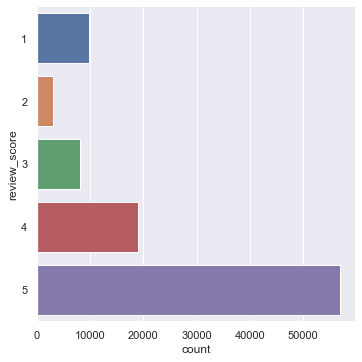

In [17]:
sb.catplot(y = "review_score", data = dataAnalysis, kind = "count")

In [18]:
# Calculating the actual wait time    
dataAnalysis.loc[:,"reviewscore"] = dataAnalysis["review_score"]//4

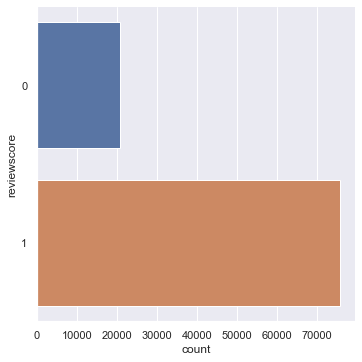

In [19]:
sb.catplot(y = "reviewscore", data = dataAnalysis, kind = "count")

The data is still imbalanced. However, it will be further balanced after being split into the different top ten product categories. 

In [20]:
# Original review score no longer needed
dataAnalysis.drop(columns = ['review_score'], inplace = True)

#### Next, narrowing down to the top ten products
`Houseware`, `auto`, `furniture decor`, `computer accessories`, `health beauty`, `sports leisure`

In [21]:
#merging with english name first 
dataAnalysis = pd.merge(dataAnalysis,product_category_name_translation,how="left",on="product_category_name")

In [22]:
dataAnalysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96674 entries, 0 to 96673
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_status                   96674 non-null  object 
 1   payment_installments           96673 non-null  float64
 2   payment_value                  96673 non-null  float64
 3   freight_value                  96674 non-null  float64
 4   product_category_name          95312 non-null  object 
 5   actual_wait_time               96666 non-null  float64
 6   actualxestimated               96666 non-null  float64
 7   reviewscore                    96674 non-null  int64  
 8   product_category_name_english  95293 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 7.4+ MB


In [23]:
housewareProd = dataAnalysis.loc[(dataAnalysis["product_category_name_english"]=="housewares")]

# Defining a balance function to balance the two classes
def balancing(dataframe):
    # Class count
    count_class_1, count_class_0 = dataframe.reviewscore.value_counts() #split the dataframe based on review scores into 1 and 0

    # Divide by class 1 and 0 to create two different dataframes
    df_class_0 = dataframe[dataframe['reviewscore'] == 0] 
    df_class_1 = dataframe[dataframe['reviewscore'] == 1]

    #Sample the class 0 (review score 0) by the number of review 1s
    df_class_0_over = df_class_0.sample(count_class_1, replace=True)
    dataframe = pd.concat([df_class_1, df_class_0_over], axis=0)
    return dataframe #return the dataframe

housewareProd = balancing(housewareProd)
housewareProd.info()
# since there is no null values, no further cleaning is required. 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9062 entries, 0 to 85499
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_status                   9062 non-null   object 
 1   payment_installments           9062 non-null   float64
 2   payment_value                  9062 non-null   float64
 3   freight_value                  9062 non-null   float64
 4   product_category_name          9062 non-null   object 
 5   actual_wait_time               9062 non-null   float64
 6   actualxestimated               9062 non-null   float64
 7   reviewscore                    9062 non-null   int64  
 8   product_category_name_english  9062 non-null   object 
dtypes: float64(5), int64(1), object(3)
memory usage: 708.0+ KB


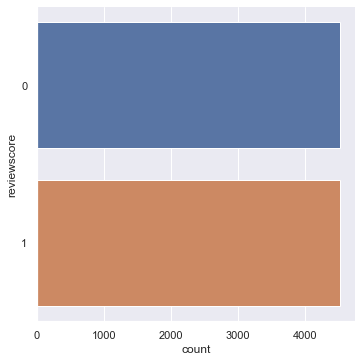

In [24]:
sb.catplot(y = "reviewscore", data = housewareProd, kind = "count") #double check if the classes are balanced. 

In [25]:
autoProd = dataAnalysis.loc[(dataAnalysis["product_category_name_english"]=="auto")]
autoProd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3797 entries, 2 to 96645
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_status                   3797 non-null   object 
 1   payment_installments           3797 non-null   float64
 2   payment_value                  3797 non-null   float64
 3   freight_value                  3797 non-null   float64
 4   product_category_name          3797 non-null   object 
 5   actual_wait_time               3796 non-null   float64
 6   actualxestimated               3796 non-null   float64
 7   reviewscore                    3797 non-null   int64  
 8   product_category_name_english  3797 non-null   object 
dtypes: float64(5), int64(1), object(3)
memory usage: 296.6+ KB


In [26]:
#Needs cleaning and removal of null values 
autoProd = autoProd.loc[(autoProd["actual_wait_time"].notnull())]
autoProd.info()
autoProd=balancing(autoProd)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3796 entries, 2 to 96645
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_status                   3796 non-null   object 
 1   payment_installments           3796 non-null   float64
 2   payment_value                  3796 non-null   float64
 3   freight_value                  3796 non-null   float64
 4   product_category_name          3796 non-null   object 
 5   actual_wait_time               3796 non-null   float64
 6   actualxestimated               3796 non-null   float64
 7   reviewscore                    3796 non-null   int64  
 8   product_category_name_english  3796 non-null   object 
dtypes: float64(5), int64(1), object(3)
memory usage: 296.6+ KB


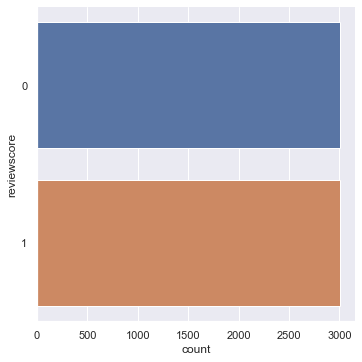

In [27]:
sb.catplot(y = "reviewscore", data = autoProd, kind = "count")

In [28]:
#No need further cleaning
furnitureProd = dataAnalysis.loc[(dataAnalysis["product_category_name_english"]=="furniture_decor")]
furnitureProd.info()

furnitureProd = balancing(furnitureProd)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6238 entries, 7 to 96668
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_status                   6238 non-null   object 
 1   payment_installments           6238 non-null   float64
 2   payment_value                  6238 non-null   float64
 3   freight_value                  6238 non-null   float64
 4   product_category_name          6238 non-null   object 
 5   actual_wait_time               6238 non-null   float64
 6   actualxestimated               6238 non-null   float64
 7   reviewscore                    6238 non-null   int64  
 8   product_category_name_english  6238 non-null   object 
dtypes: float64(5), int64(1), object(3)
memory usage: 487.3+ KB


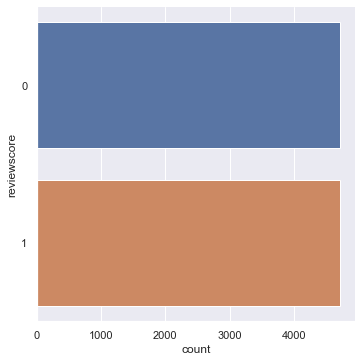

In [29]:
sb.catplot(y = "reviewscore", data = furnitureProd, kind = "count")

In [30]:
CompAcProd = dataAnalysis.loc[(dataAnalysis["product_category_name_english"]=="computers_accessories")]
CompAcProd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6522 entries, 10 to 96672
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_status                   6522 non-null   object 
 1   payment_installments           6522 non-null   float64
 2   payment_value                  6522 non-null   float64
 3   freight_value                  6522 non-null   float64
 4   product_category_name          6522 non-null   object 
 5   actual_wait_time               6521 non-null   float64
 6   actualxestimated               6521 non-null   float64
 7   reviewscore                    6522 non-null   int64  
 8   product_category_name_english  6522 non-null   object 
dtypes: float64(5), int64(1), object(3)
memory usage: 509.5+ KB


In [31]:
#Needs cleaning and removal of null values 
CompAcProd = CompAcProd.loc[(CompAcProd["actual_wait_time"].notnull())]
CompAcProd.info()
CompAcProd=balancing(CompAcProd)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6521 entries, 10 to 96672
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_status                   6521 non-null   object 
 1   payment_installments           6521 non-null   float64
 2   payment_value                  6521 non-null   float64
 3   freight_value                  6521 non-null   float64
 4   product_category_name          6521 non-null   object 
 5   actual_wait_time               6521 non-null   float64
 6   actualxestimated               6521 non-null   float64
 7   reviewscore                    6521 non-null   int64  
 8   product_category_name_english  6521 non-null   object 
dtypes: float64(5), int64(1), object(3)
memory usage: 509.5+ KB


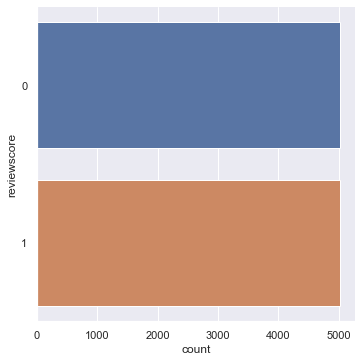

In [32]:
sb.catplot(y = "reviewscore", data = CompAcProd, kind = "count")

In [33]:
healthProd = dataAnalysis.loc[(dataAnalysis["product_category_name_english"]=="health_beauty")]
healthProd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8621 entries, 19 to 96673
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_status                   8621 non-null   object 
 1   payment_installments           8620 non-null   float64
 2   payment_value                  8620 non-null   float64
 3   freight_value                  8621 non-null   float64
 4   product_category_name          8621 non-null   object 
 5   actual_wait_time               8621 non-null   float64
 6   actualxestimated               8621 non-null   float64
 7   reviewscore                    8621 non-null   int64  
 8   product_category_name_english  8621 non-null   object 
dtypes: float64(5), int64(1), object(3)
memory usage: 673.5+ KB


In [34]:
#Needs further cleaning 
healthProd = healthProd.loc[(healthProd["payment_installments"].notnull())]
healthProd.info()
healthProd=balancing(healthProd)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8620 entries, 19 to 96673
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_status                   8620 non-null   object 
 1   payment_installments           8620 non-null   float64
 2   payment_value                  8620 non-null   float64
 3   freight_value                  8620 non-null   float64
 4   product_category_name          8620 non-null   object 
 5   actual_wait_time               8620 non-null   float64
 6   actualxestimated               8620 non-null   float64
 7   reviewscore                    8620 non-null   int64  
 8   product_category_name_english  8620 non-null   object 
dtypes: float64(5), int64(1), object(3)
memory usage: 673.4+ KB


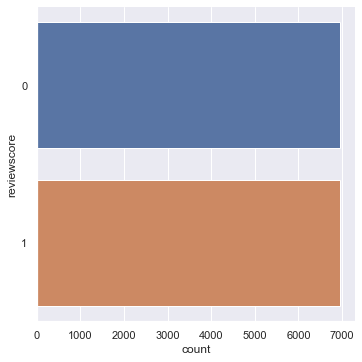

In [35]:
sb.catplot(y = "reviewscore", data = healthProd, kind = "count")

In [36]:
sportsProd = dataAnalysis.loc[(dataAnalysis["product_category_name_english"]=="sports_leisure")]
sportsProd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7504 entries, 41 to 96663
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_status                   7504 non-null   object 
 1   payment_installments           7504 non-null   float64
 2   payment_value                  7504 non-null   float64
 3   freight_value                  7504 non-null   float64
 4   product_category_name          7504 non-null   object 
 5   actual_wait_time               7503 non-null   float64
 6   actualxestimated               7503 non-null   float64
 7   reviewscore                    7504 non-null   int64  
 8   product_category_name_english  7504 non-null   object 
dtypes: float64(5), int64(1), object(3)
memory usage: 586.2+ KB


In [37]:
#Needs further cleaning 
sportsProd = sportsProd.loc[(sportsProd["actual_wait_time"].notnull())]
sportsProd.info()
sportsProd=balancing(sportsProd)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7503 entries, 41 to 96663
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_status                   7503 non-null   object 
 1   payment_installments           7503 non-null   float64
 2   payment_value                  7503 non-null   float64
 3   freight_value                  7503 non-null   float64
 4   product_category_name          7503 non-null   object 
 5   actual_wait_time               7503 non-null   float64
 6   actualxestimated               7503 non-null   float64
 7   reviewscore                    7503 non-null   int64  
 8   product_category_name_english  7503 non-null   object 
dtypes: float64(5), int64(1), object(3)
memory usage: 586.2+ KB


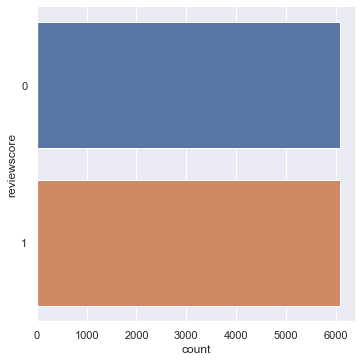

In [38]:
sb.catplot(y = "reviewscore", data = sportsProd, kind = "count")

#### Desicion tree on the product types 
`Houseware`, `auto`, `furniture decor`, `computer accessories`, `health beauty`, `sports leisure`

In [39]:
def train_and_predict(dataframe):
    # Import essential models and functions from sklearn
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import confusion_matrix

    # Extract Response and Predictors
    y = pd.DataFrame(dataframe['reviewscore'])
    X = pd.DataFrame(dataframe[["payment_installments", "payment_value", "freight_value", "actual_wait_time", "actualxestimated"]]) 

    # Split the Dataset into Train and Test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

    # Import RandomForestClassifier model from Scikit-Learn
    from sklearn.ensemble import RandomForestClassifier

    # Create the Random Forest object
    rforest = RandomForestClassifier(n_estimators = 1000,  # n_estimators denote number of trees
                                     max_depth = 6)       # set the maximum depth of each tree, following the same max depth for decision tree

    # Fit Random Forest on Train Data
    rforest.fit(X_train, y_train.reviewscore.ravel())

    # Predict the Response corresponding to Predictors
    y_train_pred = rforest.predict(X_train)
    y_test_pred = rforest.predict(X_test)
    
    # Check the Goodness of Fit (on Train Data)
    print("Goodness of Fit of Model: Train Dataset")
    print("Classification Accuracy : ", rforest.score(X_train, y_train))
    confusion_matrix_train = confusion_matrix(y_train, y_train_pred)
    TN = confusion_matrix_train[0,0]
    TP = confusion_matrix_train[1,1]
    FP = confusion_matrix_train[0,1]
    FN = confusion_matrix_train[1,0]
    print("True Negative Rate      : ", TN/(TN+FP))
    print("True Positive Rate      : ", TP/(TP+FN))
    print("False Negative Rate     : ", FN/(FN+TP))
    print("False Positive Rate     : ", FP/(TN+FP))
    print()

    # Check the Goodness of Fit (on Test Data)
    print("Goodness of Fit of Model: Test Dataset")
    print("Classification Accuracy : ", rforest.score(X_test, y_test))
    confusion_matrix_test = confusion_matrix(y_test, y_test_pred)
    TN = confusion_matrix_test[0,0]
    TP = confusion_matrix_test[1,1]
    FP = confusion_matrix_test[0,1]
    FN = confusion_matrix_test[1,0]
    print("True Negative Rate      : ", TN/(TN+FP))
    print("True Positive Rate      : ", TP/(TP+FN))
    print("False Negative Rate     : ",FN/(FN+TP))
    print("False Positive Rate     : ", FP/(TN+FP))

    # Plot the Confusion Matrix for Train and Test
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    sb.heatmap(confusion_matrix(y_train, y_train_pred),
               annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0], cmap="Blues")
    sb.heatmap(confusion_matrix(y_test, y_test_pred), 
               annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1], cmap="Blues")

Goodness of Fit of Model: Train Dataset
Classification Accuracy :  0.6813403416557161
True Negative Rate      :  0.4463301741238704
True Positive Rate      :  0.9133841131664853
False Negative Rate     :  0.08661588683351469
False Positive Rate     :  0.5536698258761296

Goodness of Fit of Model: Test Dataset
Classification Accuracy :  0.6678712220762155
True Negative Rate      :  0.4455190199871051
True Positive Rate      :  0.898861352980576
False Negative Rate     :  0.10113864701942397
False Positive Rate     :  0.5544809800128949


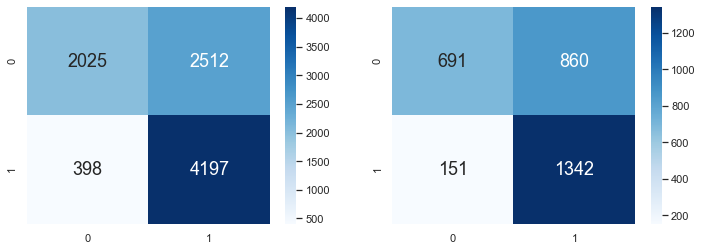

In [40]:
train_and_predict(sportsProd)

Goodness of Fit of Model: Train Dataset
Classification Accuracy :  0.6701000588581518
True Negative Rate      :  0.47857981220657275
True Positive Rate      :  0.8627508854781583
False Negative Rate     :  0.1372491145218418
False Positive Rate     :  0.5214201877934272

Goodness of Fit of Model: Test Dataset
Classification Accuracy :  0.6438658428949691
True Negative Rate      :  0.46215494211932323
True Positive Rate      :  0.8223972003499562
False Negative Rate     :  0.17760279965004375
False Positive Rate     :  0.5378450578806767


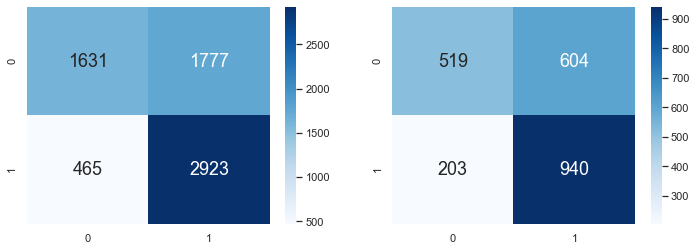

In [41]:
train_and_predict(housewareProd)

Goodness of Fit of Model: Train Dataset
Classification Accuracy :  0.6851940584571155
True Negative Rate      :  0.4974152785755313
True Positive Rate      :  0.8733691481197237
False Negative Rate     :  0.12663085188027629
False Positive Rate     :  0.5025847214244687

Goodness of Fit of Model: Test Dataset
Classification Accuracy :  0.6576602471974705
True Negative Rate      :  0.4596309111880046
True Positive Rate      :  0.8544412607449857
False Negative Rate     :  0.14555873925501434
False Positive Rate     :  0.5403690888119954


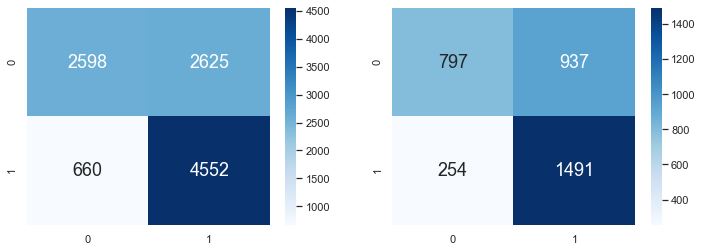

In [42]:
train_and_predict(healthProd)

Goodness of Fit of Model: Train Dataset
Classification Accuracy :  0.6917960088691796
True Negative Rate      :  0.4477152899824253
True Positive Rate      :  0.9404655326768129
False Negative Rate     :  0.05953446732318711
False Positive Rate     :  0.5522847100175747

Goodness of Fit of Model: Test Dataset
Classification Accuracy :  0.6642287234042553
True Negative Rate      :  0.3953488372093023
True Positive Rate      :  0.9184993531694696
False Negative Rate     :  0.0815006468305304
False Positive Rate     :  0.6046511627906976


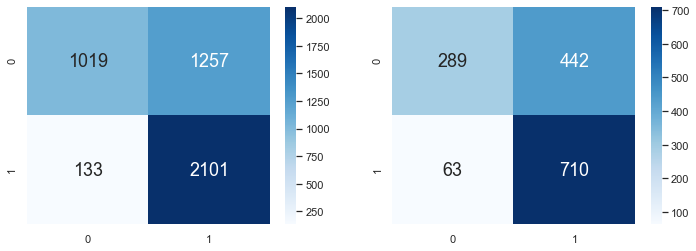

In [43]:
train_and_predict(autoProd)

Goodness of Fit of Model: Train Dataset
Classification Accuracy :  0.6808651804670913
True Negative Rate      :  0.4835341365461847
True Positive Rate      :  0.8747697974217311
False Negative Rate     :  0.1252302025782689
False Positive Rate     :  0.5164658634538153

Goodness of Fit of Model: Test Dataset
Classification Accuracy :  0.6297770700636943
True Negative Rate      :  0.42668735453840184
True Positive Rate      :  0.8438266557645135
False Negative Rate     :  0.1561733442354865
False Positive Rate     :  0.5733126454615981


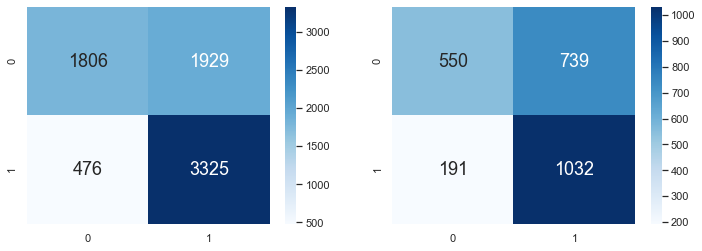

In [44]:
train_and_predict(CompAcProd)

Goodness of Fit of Model: Train Dataset
Classification Accuracy :  0.6816320768036143
True Negative Rate      :  0.4491597835374537
True Positive Rate      :  0.9101343784994401
False Negative Rate     :  0.0898656215005599
False Positive Rate     :  0.5508402164625463

Goodness of Fit of Model: Test Dataset
Classification Accuracy :  0.6378653113087674
True Negative Rate      :  0.4087530966143683
True Positive Rate      :  0.8791304347826087
False Negative Rate     :  0.1208695652173913
False Positive Rate     :  0.5912469033856317


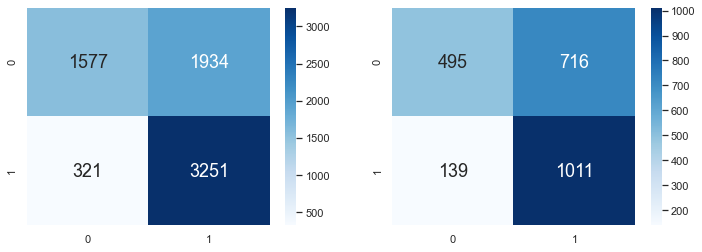

In [45]:
train_and_predict(furnitureProd)

# Check Point: Analysis 


There is a significant improvement in the performance of the machine learning model when using random forest as opposed to using decision tree. The classification accuracy increases to almost 80% for most product types. Additionally, the false positive rates drop below 30%. However, more can be done to find the hyperparameters which results in the most accurate random forest model being made. 

**Hyperparameters** 
Hyperparameters in this case is the `n_estimators` and the `max_depth` which is the number of decision trees in the forest and the maximum depth each tree respectively. Grid Search is used to find the best hyperparameters. 

In [46]:
def best_hyperparameter(dataframe):
    # Import essential models and functions from sklearn
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import confusion_matrix
    # Import RandomForestClassifier model from Scikit-Learn
    from sklearn.ensemble import RandomForestClassifier

    # Extract Response and Predictors
    y = pd.DataFrame(dataframe['reviewscore'])
    X = pd.DataFrame(dataframe[["payment_installments", "payment_value", "freight_value", "actual_wait_time", "actualxestimated"]]) 

    # Split the Dataset into Train and Test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
    # Import GridSearch for hyperparameter tuning using Cross-Validation (CV)
    from sklearn.model_selection import GridSearchCV

    # Define the Hyper-parameter Grid to search on, in case of Random Forest
    param_grid = {'n_estimators': np.arange(100,1001,100),   # number of trees 100, 200, ..., 1000
                  'max_depth': np.arange(2, 11)}             # depth of trees 2, 3, 4, 5, ..., 10

    # Create the Hyper-parameter Grid
    hpGrid = GridSearchCV(RandomForestClassifier(),   # the model family
                          param_grid,                 # the search grid
                          cv = 5,                     # 5-fold cross-validation
                          scoring = 'accuracy')       # score to evaluate

    # Train the models using Cross-Validation
    hpGrid.fit(X_train, y_train.reviewscore.ravel())
    
    # Fetch the best Model or the best set of Hyper-parameters
    print(hpGrid.best_estimator_)

    # Print the score (accuracy) of the best Model after CV
    print(np.abs(hpGrid.best_score_))


In [47]:
best_hyperparameter(furnitureProd)

RandomForestClassifier(max_depth=10, n_estimators=500)
0.7314691657795374


In [48]:
best_hyperparameter(healthProd)

RandomForestClassifier(max_depth=10, n_estimators=600)
0.7387637757546719


In [49]:
best_hyperparameter(autoProd)

RandomForestClassifier(max_depth=10, n_estimators=500)
0.76940133037694


In [50]:
best_hyperparameter(CompAcProd)

RandomForestClassifier(max_depth=10, n_estimators=800)
0.7336793460755203


In [51]:
best_hyperparameter(sportsProd)

RandomForestClassifier(max_depth=10)
0.7362029098630678


In [52]:
best_hyperparameter(housewareProd)

RandomForestClassifier(max_depth=10, n_estimators=200)
0.7248384408951218
